In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import cv2
import matplotlib.image as mpimg
import pydicom
import time
# from skimage import io
from scipy.ndimage import gaussian_filter

In [2]:
PATH = "src\\"

In [3]:
pi = np.pi

In [4]:
def read_file(direc, file, normalization):
    file = pydicom.read_file(direc+file)
    img = file.pixel_array
    if normalization == 1:
        data = img/(np.max(img)-np.min(img))  #normalization
    else:
        data = img
    return img, data

In [5]:
def initial_curve(center, width, img_size_row, img_size_col):
    initial_map = np.ones((img_size_row,img_size_col))*-2
    initial_map[center[0]-width:center[0]+width,center[1]-width:center[1]+width] *= -1
    return initial_map

In [6]:
def force(image,s_gradient, mean1, mean2):
    edge_constrain = 1/(1+s_gradient)
    f1 = (image-mean1)**2
    f2 = (image-mean2)**2
    eps = 1e-5
    return (1/2+f1*edge_constrain+eps)/((1+(f1+f2)*edge_constrain+2*eps)), (1/2+f2*edge_constrain+eps)/((1+(f1+f2)*edge_constrain+2*eps)) 

In [7]:
def delta(phi, eps):
    return 1/pi*(eps/(phi**2+eps**2)) #分析最大值

In [8]:
def gradient_square(img):
    return (np.gradient(img)[1])**2+(np.gradient(img)[0])**2

In [9]:
def K(phi):
    phi_x = np.gradient(phi)[1]
    phi_y = np.gradient(phi)[0]
    phi_xx = np.gradient(phi_x)[1]
    phi_xy = np.gradient(phi_x)[0]
    phi_yy = np.gradient(phi_y)[0]
    
    return (phi_xx * phi_y**2 + phi_yy * phi_x**2 - 2*phi_xy * phi_y*phi_x+1e-10)/((phi_x**2 + phi_y**2)**(3/2)+1e-10),  phi_xx+phi_yy

In [10]:
def show_contour(img, phi):
    plt.clf()
    plt.imshow(img,cmap = plt.cm.bone)
    plt.contour(phi,[0],colors='r',linewidths = 0.5) 
    plt.show()

In [11]:
def calculate_mean(img, phi, gradient):
    weight = 1/(1+gradient)
    c_1 = np.sum(img[(phi>0)]*(weight[(phi>0)]))/np.sum(weight[(phi>0)])
    c_2 = np.sum(img[(phi<0)]*(weight[(phi<0)]))/np.sum(weight[(phi<0)])

    return c_1, c_2

In [12]:
def evolution(data, phi, gamma1, gamma2, eta, gs_img, c1, c2, t_2, eps):
    f1, f2 = force(data, gs_img, c1, c2)
    
    curvature, _ = K(phi)
    
    phi_t = phi - delta(phi,eps)*(gamma1*f1-gamma2*f2-eta*curvature)
    
    _, laplacian = K(phi_t)
    phi_t = phi_t+t_2*laplacian
    c1_t, c2_t = calculate_mean(data, phi_t, gs_img)

    return c1_t, c2_t, phi_t #, functional(gamma1, gamma2, eta, f1, f2, phi_t, eps),f1, f2

In [13]:
def functional(gamma1, gamma2, eta, f1, f2, phi, eps):
     return np.sum(gamma1*f1*((phi>0).astype('int'))+gamma2*f2*((phi<0).astype('int'))+eta*delta(phi, eps)*gradient_square(phi)**0.5)
    

In [14]:
def main(img, data, center, width, eta, t_2, max_iteration, plot = 1):
    img_size_row, img_size_col= len(img), len(img[0])
    phi = (initial_curve(center, width, img_size_row, img_size_col))
    phi = phi/(np.max(phi)-np.min(phi))
    gs_img = gradient_square(data)

    c1 = np.mean(data[phi>0]) 
    c2 = np.mean(data[phi<0]) 
    start = time.time()
#     energy_array = []
    for t in range(0,max_iteration):
        
        c1_t, c2_t, phi_t = evolution(data, phi, 1, 1, eta, gs_img, c1, c2, t_2, 0.05)
        
#         energy_array.append(energy_t)
        if plot == 1:
            if  (t % 1 == 0):
                show_contour(img, phi)
                print(t)
        
        phi = phi_t        
        c1 = c1_t
        c2 = c2_t
    end = time.time()
    return phi, end-start

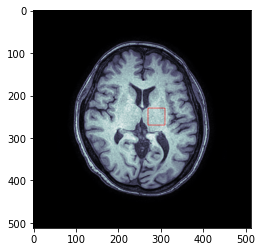

0


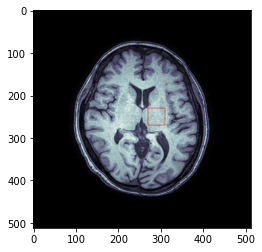

1


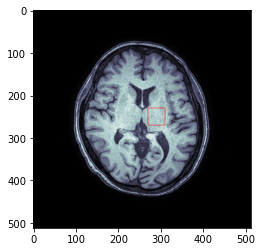

2


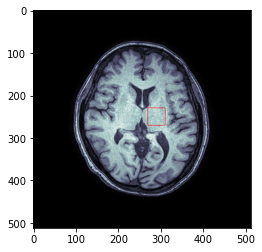

3


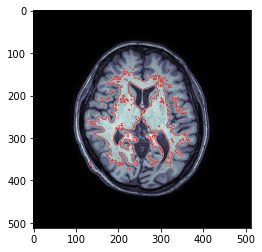

4
3.869439125061035


In [112]:
img, data = read_file(PATH, '80',1)
# img = io.imread('4.bmp')
ground_truth, duration = main(img, img, [250,290], 20, 1e-2, 0.1, 5,1)
print (duration)


In [324]:
img

array([[129, 131, 132, ...,  97,  97,  99],
       [132, 135, 135, ...,  97,  97,  98],
       [134, 137, 138, ...,  96,  96,  97],
       ...,
       [228, 232, 233, ...,  98,  98,  98],
       [225, 228, 229, ...,  96,  96,  96],
       [217, 222, 223, ...,  96,  96,  96]], dtype=uint8)

In [35]:
from skimage import io

In [36]:
file = pydicom.read_file(PATH+'80')
# plt.imshow(file.pixel_array, cmap = plt.cm.bone)
plt.imsave('image.png',file.pixel_array,cmap = plt.cm.bone)

In [152]:
%matplotlib qt
img_result = (io.imread('image.png', as_gray=False)[:,:,0:3])
fig1 = plt.figure()
img_result[img<20] = [0,0,0]
img_result[img>20] = img_result[img>20] 
# plt.imsave('90.bmp', img_result, dpi = 500)
# plt.clf()
plt.imshow(img_result)

# plt.show()
fig2 = plt.figure()
img_result[ground_truth<0] = [241,160,88]
img_result[ground_truth>0] = img_result[ground_truth>0]
img_result[img<20] = [0,0,0]
plt.imshow(img_result)
# plt.show()
# plt.imsave('100_result_combine.bmp', img_result, dpi = 500)
# plt.clf()

#     img_result[ground_truth<0] = [241,160,88]
fig3 = plt.figure()
img_result[ground_truth>0] = [0,0,0]
img_result[img<20] = [0,0,0]
plt.imshow(img_result)
# plt.show()
# plt.imsave('100_result_inside.bmp', img_result, dpi = 500)
# plt.clf()
fig4 = plt.figure()
img_result[ground_truth<0] = [170,170,170]
img_result[ground_truth>0] = [255,255,255]
img_result[img<20] = [0,0,0]
plt.imshow(img_result)
# plt.show()
# plt.imsave('100_binary.bmp', img_result, dpi = 500)
# plt.clf()

# Noise experience

In [15]:
image_set = ['80', '90', '100', '105']
center_parameter_set = [[250,290], [250,200], [200, 200], [200, 200]]
radii_set = [20,20,20,20]
eta_set = [1e-2, 1e-4, 1e-2, 1e-3]
t_2_set = [0.1, 0.1, 0.15, 0.15]
iteration_set = [5, 6, 6, 5]


In [16]:
def dice_score(ground_truth, result):
    a = np.sum(((ground_truth>0)&(result>0)).astype(int))
    b = np.sum(((ground_truth>0)).astype(int))
    c = np.sum(((result>0)).astype(int))
    d = np.sum(((ground_truth>0)|(result>0)).astype(int))
    return a/d

In [17]:
def SSIMnp(y_true , y_pred):
    u_true = np.mean(y_true)
    u_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    std_true = np.sqrt(var_true)
    std_pred = np.sqrt(var_pred)
    c1 = np.square(0.01*7)
    c2 = np.square(0.03*7)
    ssim = (2 * u_true * u_pred + c1) * (2 * std_pred * std_true + c2)
    denom = (u_true ** 2 + u_pred ** 2 + c1) * (var_pred + var_true + c2)
    return ssim / denom

In [18]:
import math
def psnr(img1, img2):
    mse = np.mean(((img1-img2)**2).flatten())
    print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = np.max(img1)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [19]:
def PepperandSalt(src,percetage):
    NoiseImg = np.copy(src)
    max_pixel = np.max(src)
    NoiseNum=int(percetage/100*src.shape[0]*src.shape[1])
    N = src.shape[0]
    M = src.shape[1]
    for i in range(NoiseNum):
        randX=np.random.randint(0,511)
        randY=np.random.randint(0,511)
        if np.random.random() <= 0.5:
            NoiseImg[randX,randY]=0
        else:
            NoiseImg[randX,randY]=max_pixel
#     NoiseImg[img<20] = 0        
    return NoiseImg


In [21]:
def convoultion(src, s):
    return gaussian_filter(src, sigma=s)
# psnr(img, PepperandSalt(img, 5))

In [23]:
gaussian_add_variance_set = [6, 8, 10,15,17,20,22,25,27,30,35,40,50, 55, 60]
gaussian_convolution_variance_set = [0.7,1, 1.3, 1.5, 1,7, 2, 2.2, 2.5,2.7, 3, 4,  5, 6, 7, 10, 12, 15]
pepper_percentage_set = [0.5, 1, 1.2, 1.5, 1.7, 2, 3, 4,  5, 6, 7, 8,  9, 10, 13, 15, 17, 19, 20]
noise_type = [gaussian_add_variance_set, gaussian_convolution_variance_set, pepper_percentage_set]

In [24]:
img, data = read_file(PATH, '90',1)

In [25]:
result = []
for noise_idx in range(len(noise_type)):
    result_noise = []
    for image_id in range(len(image_set)):
        img = pydicom.read_file(PATH+image_set[image_id]).pixel_array
        
        for test_para in noise_type[noise_idx]:
            if noise_idx == 0:
                noise_image = np.copy(img)+np.random.normal(0, test_para, (512,512))
            elif noise_idx == 1:
                noise_image = convoultion(img, test_para)
            elif noise_idx == 2:
                noise_image = PepperandSalt(img, test_para)
           
            noise_image[img<20] = 0
            
            ground_truth, _ = main(img, img, center_parameter_set[image_id],
                                   radii_set[image_id],
                                   eta_set[image_id],
                                   t_2_set[image_id], iteration_set[image_id], 0)

            noise_result, _ = main(noise_image, noise_image, center_parameter_set[image_id],
                                   radii_set[image_id],
                                   eta_set[image_id],
                                   t_2_set[image_id], iteration_set[image_id], 0)
            result_noise.append(np.array([psnr(img,noise_image), dice_score(ground_truth, noise_result)]))
    result.append(np.array(result_noise))     

17.627318104361706
27.040211415423837
38.929105623584256
80.67368211192304
101.89799263107929
138.70155592755788
168.12143751688996
212.96211261244997
248.02930813278272
306.0347267744942
415.745699805938
535.5853055651804
841.6974003345825
1011.4906606730962
1201.492204141705
17.349273945846043
26.308982473304017
38.11873315252038
78.36644702113999
98.91242804117422
135.80642780303813
162.5241994249186
210.17989524503542
244.01448164797563
300.2735533287827
403.63305764955544
524.0312602751012
818.8169869680944
985.5375404858543
1166.0476158560818
16.815218361804355
25.368417663466477
36.89849226217598
75.53910490357717
94.8273900016441
129.3846336637061
155.71835081521616
199.9217408065607
229.9300035440061
286.0944709979944
382.6015022332935
495.4201373068888
781.4460015060669
947.5601235488473
1113.9806557124355
16.389653283360996
24.874970878898683
35.6888770975789
73.42923234292434
92.27356680118396
125.15117377057618
149.50845941846194
192.31052624410265
222.08963758261157
271.6

In [26]:
gauss_add = result[0]
gauss_convol = result[1]
pepper = result[2]

In [28]:
len(gauss_add)

60

In [29]:
thresholds = [30,27,25, 23, 20]

In [30]:
gauss_add_gps = [gauss_add[(gauss_add[:,0]>=thresholds[0])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[0])&(gauss_add[:,0]>=thresholds[1])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[1])&(gauss_add[:,0]>=thresholds[2])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[2])&(gauss_add[:,0]>=thresholds[3])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[3])&(gauss_add[:,0]>=thresholds[4])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[4])][:,1]]

gauss_convol_gps = [gauss_convol[(gauss_convol[:,0]>=thresholds[0])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[0])&(gauss_convol[:,0]>=thresholds[1])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[1])&(gauss_convol[:,0]>=thresholds[2])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[2])&(gauss_convol[:,0]>=thresholds[3])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[3])&(gauss_convol[:,0]>=thresholds[4])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[4])][:,1]]

pepper_gps = [pepper[(pepper[:,0]>=thresholds[0])][:,1],
 pepper[(pepper[:,0]<thresholds[0])&(pepper[:,0]>=thresholds[1])][:,1],
 pepper[(pepper[:,0]<thresholds[1])&(pepper[:,0]>=thresholds[2])][:,1],
 pepper[(pepper[:,0]<thresholds[2])&(pepper[:,0]>=thresholds[3])][:,1],
 pepper[(pepper[:,0]<thresholds[3])&(pepper[:,0]>=thresholds[4])][:,1],
 pepper[(pepper[:,0]<thresholds[4])][:,1]]

In [33]:
gauss_convol_gps

[array([0.97137792, 0.95159776, 0.9338302 , 0.95159776, 0.97425142,
        0.9542842 , 0.94010693, 0.93082154, 0.9542842 , 0.97417447,
        0.95150614, 0.93258271, 0.91981296, 0.95150614, 0.97751945,
        0.96039755, 0.94244823, 0.93087403, 0.96039755]),
 array([0.92110476, 0.89258716, 0.8827091 , 0.90698621, 0.89869695,
        0.88709101, 0.87958688, 0.89739621, 0.89019689, 0.8804165 ,
        0.87416563, 0.86516725, 0.90300497, 0.89352048, 0.88012066,
        0.871703  , 0.85894471]),
 array([0.8674868 , 0.85739116, 0.84426986, 0.80142707, 0.8679017 ,
        0.83215539, 0.83423094, 0.80331646, 0.80579257]),
 array([0.76652836, 0.73723022, 0.76827829, 0.80616821, 0.78548369,
        0.76827829, 0.75870931, 0.77839366, 0.75870931, 0.68668588,
        0.76050639, 0.71651767, 0.68668588]),
 array([0.71070846, 0.71070846, 0.65678087, 0.63508381, 0.61855494,
        0.7322987 , 0.71161213, 0.69096637, 0.73213363, 0.72324975,
        0.71207705, 0.65744322, 0.64988306, 0.64364919])

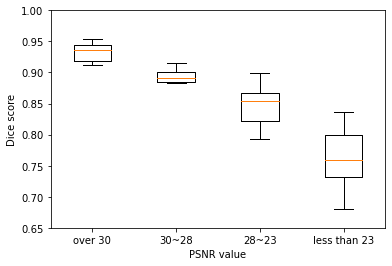

In [288]:
plt.figure()
bp = plt.boxplot(gauss_add_gps[:-1], labels = ['over 30', '30~28', '28~23', 'less than 23'])
plt.xlabel('PSNR value')
plt.ylabel('Dice score')
plt.ylim(0.65,1)
plt.savefig('gaussian_noise.png', dpi = 500)

In [290]:
gauss_convol_gps

[array([0.99867865, 0.9857688 , 0.95159776, 0.99865994, 0.98583735,
        0.9542842 , 0.93082154, 0.99822571, 0.98511155, 0.95150614,
        0.91981296, 0.99848405, 0.9889665 , 0.96039755, 0.93087403]),
 array([0.92110476, 0.89258716, 0.90698621, 0.89739621, 0.90300497]),
 array([0.8674868 , 0.84426986, 0.76652836, 0.88709101, 0.8679017 ,
        0.80616821, 0.76827829, 0.8804165 , 0.86516725, 0.80331646,
        0.75870931, 0.88012066, 0.85894471, 0.76050639, 0.68668588]),
 array([0.71070846, 0.65678087, 0.7322987 , 0.73213363, 0.65744322]),
 array([], dtype=float64)]

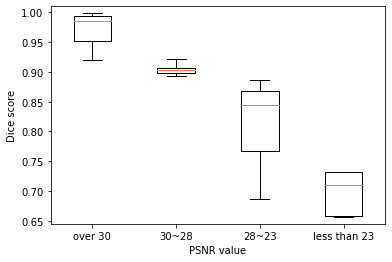

In [294]:
plt.figure()
bp = plt.boxplot(gauss_convol_gps[:-1], labels = ['over 30', '30~28', '28~23', 'less than 23'])
plt.xlabel('PSNR value')
plt.ylabel('Dice score')
plt.ylim(0.645,1.01)
plt.savefig('gaussian_convol_noise.png', dpi = 500)

In [304]:
pepper_gps

[array([0.98284847, 0.98578222, 0.98727599, 0.97961443]),
 array([0.95028325, 0.95045109, 0.96022884, 0.95522801]),
 array([0.92173282, 0.92282816, 0.94126534, 0.92255348]),
 array([0.86898943, 0.85021596, 0.88438889, 0.86734482, 0.90371238,
        0.88968897, 0.87011529, 0.84359242]),
 array([0.82429595, 0.76546915, 0.84174846, 0.81027402, 0.87839677,
        0.80396834, 0.80416897, 0.73440384])]

(0.645, 1.01)

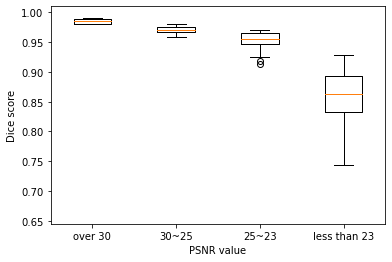

In [379]:
plt.figure()
bp = plt.boxplot([pepper_gps[0],pepper_gps[1], pepper_gps[2], np.append(pepper_gps[3], pepper_gps[4])], labels = ['over 30', '30~25', '25~23', 'less than 23'])
plt.xlabel('PSNR value')
plt.ylabel('Dice score')
plt.ylim(0.645,1.01)
# plt.savefig('gaussian_convol_noise.png', dpi = 500)

In [270]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

{'whiskers': [<matplotlib.lines.Line2D at 0x23ad80403d0>,
 'caps': [<matplotlib.lines.Line2D at 0x23ad806d580>,
 'boxes': [<matplotlib.lines.Line2D at 0x23ad8040c70>,
 'medians': [<matplotlib.lines.Line2D at 0x23ad806d400>,
 'fliers': [<matplotlib.lines.Line2D at 0x23ad806dca0>,
 'means': []}

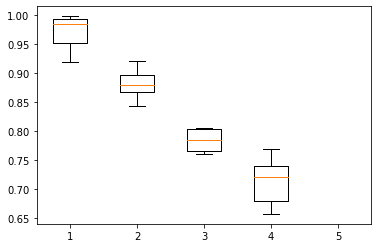

In [260]:
plt.boxplot(gauss_convol_gps)

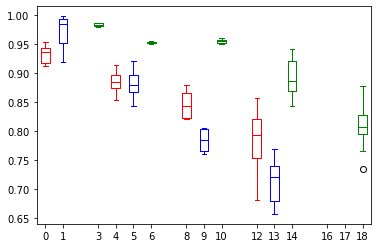

In [271]:
bp1 = plt.boxplot(gauss_add_gps, positions = [0,4,8,12,16])
bp2 = plt.boxplot(gauss_convol_gps, positions = [1,5,9,13,17])
bp3 = plt.boxplot(pepper_gps, positions = [3,6,10,14,18])
set_box_color(bp1, 'red')
set_box_color(bp2, 'blue')
set_box_color(bp3, 'green')

In [319]:
np.mean(np.array(gauss_add_gps[:-1]), axis=1)

<ipython-input-319-e654b5537a7a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.mean(np.array(gauss_add_gps[:-1]), axis=1)


AxisError: axis 1 is out of bounds for array of dimension 1

In [356]:
pepper_gps

[array([0.99867865, 0.9857688 , 0.95159776, 0.99865994, 0.98583735,
        0.9542842 , 0.93082154, 0.99822571, 0.98511155, 0.95150614,
        0.91981296, 0.99848405, 0.9889665 , 0.96039755, 0.93087403]),
 array([0.92110476, 0.89258716, 0.8674868 , 0.84426986, 0.90698621,
        0.88709101, 0.8679017 , 0.89739621, 0.8804165 , 0.86516725,
        0.80331646, 0.90300497, 0.88012066, 0.85894471]),
 array([0.76652836, 0.80616821, 0.76827829, 0.75870931, 0.76050639,
        0.68668588]),
 array([0.71070846, 0.65678087, 0.7322987 , 0.73213363, 0.65744322]),
 array([], dtype=float64)]

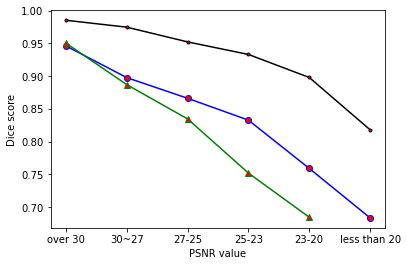

In [42]:
plt.plot(np.arange(len(gauss_add_gps)), [np.mean(i) for i in np.array(gauss_add_gps, dtype='object')], 'ob-' , mfc = 'r')
plt.plot(np.arange(len(gauss_convol_gps[:-1])), [np.mean(i) for i in np.array(gauss_convol_gps[:-1], dtype='object')], '^g-' , mfc = 'r')
plt.plot(np.arange(len(pepper_gps)), [np.mean(i) for i in np.array(pepper_gps, dtype='object')], '.k-' , mfc = 'r')
plt.xlabel('PSNR value')
plt.ylabel('Dice score')
plt.xticks([0,1,2,3,4,5], ['over 30','30~27','27-25', '25-23', '23-20', 'less than 20'])
plt.show()

In [143]:
gp_1 = np.append(DICE_score_result[:,:,1][0],DICE_score_result[:,:,1][1])
gp_2 = np.append(DICE_score_result[:,:,1][2],DICE_score_result[:,:,1][3])
gp_3 = np.append(DICE_score_result[:,:,1][4],DICE_score_result[:,:,1][5])
gp_ = np.append(DICE_score_result[:,:,1][6],DICE_score_result[:,:,1][7])

In [149]:
gp_4

array([0.76023744, 0.81525353, 0.83921773, 0.74567062, 0.70167275,
       0.76902267, 0.79036576, 0.65057626])

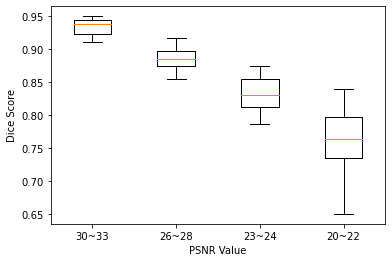

In [151]:
labels = ['30~33', '26~28', '23~24', '20~22']
plt.boxplot([gp_1, gp_2, gp_3, gp_4], labels = labels)
plt.xlabel('PSNR Value')
plt.ylabel('Dice Score')
# plt.show()
plt.savefig('Dice score experimence.png', dpi = 500)

In [91]:
s = np.random.normal(0, 30, (512,512))
gaussian_noise = np.copy(img)+s.astype(int)

In [92]:
gaussian_noise[img<20] = 0

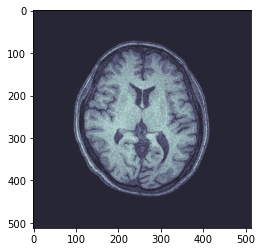

In [93]:
plt.imshow(gaussian_noise, cmap = plt.cm.bone)
plt.show()

In [94]:
d=psnr(img,gaussian_noise)
print(d)

298.339656829834
25.108097922154187


In [95]:
plt.imsave('Gaussian_noise_SNR_'+str(round(d,2))+'.png', gaussian_noise,cmap = plt.cm.bone, dpi = 150)

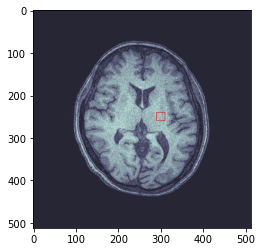

0


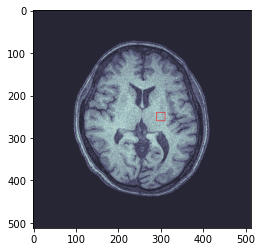

1


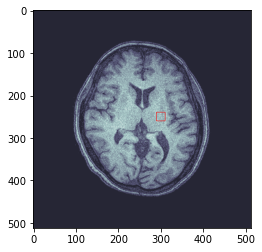

2


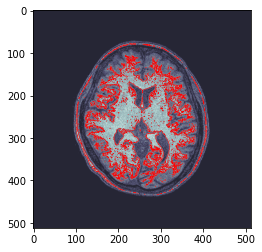

3


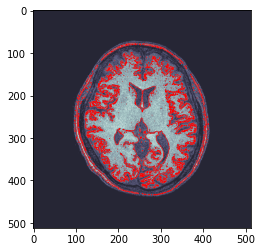

4


In [96]:
test, _ = main(gaussian_noise,  gaussian_noise, [250,300], 10, 5,1)

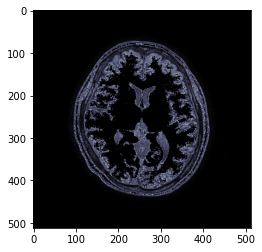

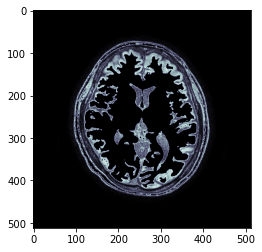

In [97]:
plt.clf()
plt.imshow(img*((test<0).astype(int)), cmap = plt.cm.bone)
# plt.imsave( 'gaussian_noise_target.png',gaussian_noise*((test<0).astype(int)),cmap = plt.cm.bone,  dpi = 500)
plt.show()
plt.clf()
plt.imshow(img*((ground_truth<0).astype(int)), cmap = plt.cm.bone)
# plt.imsave( 'IM120_back.png',img*((ground_truth>0).astype(int)),cmap = plt.cm.bone,  dpi = 500)
plt.show()

In [99]:
dice_score(ground_truth, test)

(0.9269934286654564, 0.8639214832696835)

In [68]:
SSIMnp(img*((ground_truth<0).astype(int)), gaussian_noise*((test<0).astype(int)))

0.9941892629793878

In [ ]:
from skimage import io
noisy_img = io.imread('SNR_'+str(round(d,2))+'.png', as_gray=False)[:,:,0:3]
plt.imshow(noisy_img)

In [ ]:
noisy_img[test<0]

In [ ]:
noisy_img[test>0] = [241,160,88]
noisy_img[pepper<350] = [0,0,0]
plt.imshow(noisy_img)

plt.imsave('SNR_'+str(round(d,2))+'result.png', noisy_img)

In [ ]:
plt.imsave('IM120.png', img, cmap = plt.cm.bone, dpi = 150)

In [ ]:
plt.clf()
clean_img = io.imread('IM120.png', as_gray=False)[:,:,0:3]
plt.imshow(clean_img)
clean_img[ground_truth>0] = [241,160,88]
clean_img[img<350] = [0,0,0]
plt.imshow(clean_img)

# plt.imsave('clean_with_SNR_'+str(round(d,2))+'result.png', clean_img)

In [ ]:
plt.plot(np.linspace(0,1,4),[0,0,0,0], 'r-', marker = 'x')
plt.plot(np.linspace(0,1,4),[1,1,1,1], 'b-', marker = 'o')
plt.plot(np.linspace(0,2/3,3), [0,0.5,1])
plt.ylabel('time')
plt.xlabel('grid')
plt.xticks(np.linspace(0,1,4),['$x_{i-1}$', '$x_i$', '$x_i$', '$x_i$'])
plt.show()

In [ ]:
np.linspace(0,1,4)
np.zeros(5)